<a id = "table_of_contents"></a>

# Índice
[Objetivos del Notebook](#objetivos)

[Importación de las Principales Librerías](#import_modules)

[GLOBAL_VARIABLES](#global_variables)

[Funciones Auxiliares](#helpers)

[Generación de un dataset](#dataset)

[Cálculo de distancias](#distances)

---> [Distancia Euclídea Sin Estandarización](#euclidea_bad)

---> [Distancia de Manhattan Sin Estandarización](#manhattan_bad)

---> [Distancia Euclídea Con Estandarización](#euclidea_bien)

---> [Distancia de Manhattan Con Estandarización](#manhattan_bien)

[Otras formas de procesar los datos](#transformers)

[Comparación de los Transformers](#scaler_comparison)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# Objetivos del Notebook
[Volver al índice](#table_of_contents)

El presente notebook busca introducir al alumno los conceptos más básicos de **Aprendizaje No Supervisado**.

La idea fundamental que aparece en muchos de los algoritmos de **Aprendizaje No Supervisado** es la de las **distancias**. 

Existen muchas definiciones y formas de calcular distancias. En este notebook veremos 2 de las más habituales: **la distancia Euclídea y la distancia de Manhattan**.

Las distancias permiten a los algoritmos calcular **la proximidad entre vectores (en nuestro caso serán clientes o personas)** y esto nos abre la posibilidad de **encontrar clientes parecidos** de una forma matemática.

En el notebook tocaremos de una u otra forma:

1. Cálculo de **forma manual** de la distancia Euclídea y de Manhattan.

2. **Aplicación de estas dos distancias a un dataset**, para encontrar en base a nuestras variables a los clientes más parecidos (los que más cerca están en nuestro espacio dimensional).

3. Aplicación de técnicas de estandarización (de forma manual) para que las variables tengan un **"peso similar"** en el cómputo global.

4. Uso de los **sklearn transformers** para replicar el paso 3 de una forma mucho más rápida y limpia.

Cerraremos el notebook con un apartado de conclusiones.

<a id = "import_modules"></a>
# Importación de las Principales Librerías
[Volver al índice](#table_of_contents)

En esta sección hacemos los imports de las principales librerías.

In [1]:
# numerical computation
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn transformers and distances functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer # transformers
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.datasets import load_boston

<a id = "global_variables"></a>
# GLOBAL_VARIABLES
[Volver al índice](#table_of_contents)

Definimos las GLOBAL_VARIABLES que afectarán a nuestro notebook.

In [2]:
COLOR = "#2a9d8f" #color para remarcar a los puntos más próximos
COLOR_MAX = "#D8E4FF"

<a id = "helpers"></a>
# Funciones Auxiliares
[Volver al índice](#table_of_contents)

Definimos las funciones que vamos a usar en el resto del notebook.

In [3]:
def plot_euclidean_distance():
    '''
    Makes a simple plot of an Euclidean distances in a 2D space.
    Returns nothing. Renders the plot on the function call.
    '''
    # instanciamos la figure y el axes
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)

    # creamos una espacio cartesiona
    lims = (-10, 10)
    alpha = 0.5
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # pintamos lineas horizontales y verticales
    ax.vlines(0, -10, 10, linestyles = "--", alpha = alpha)
    ax.hlines(0, -10, 10, linestyles = "--", alpha = alpha)

    # pintamos los dos catetos y la hipotenusa
    ax.plot([0, 5], [0, 5], alpha = alpha, color = "red", lw = 2) # hipotenusa
    ax.text(2, 3.5, s = "d", fontsize = 8, color = "red")

    ax.plot([0, 5], [0, 0], alpha = alpha, color = "blue", lw = 2) # cateto azul
    ax.text(1.5, -1, s = "x2 - x1", fontsize = 8, color = "blue")

    ax.plot([5, 5], [5, 0], alpha = alpha, color = "green", lw = 2) # cateto verde

    # origen
    ax.scatter([0, 0], [0, 0], alpha = alpha, color = "black", lw = 2)
    ax.text(-1, -1, s = "(x1, y1)", fontsize = 8, color = "black")

    # punto 2
    ax.scatter([0, 5], [0, 5], alpha = alpha, color = "black", lw = 2)
    ax.text(5.5, 5.5, s = "(x2, y2)", fontsize = 8, color = "black")

    # punto en el eje x
    ax.scatter([5, 0], [0, 0], alpha = alpha, color = "black", lw = 2)

    # cálculo
    ax.text(1.5, -1, s = "x2 - x1", fontsize = 8, color = "blue")
    ax.text(5.5, 2, s = "y2 - y1", fontsize = 8, color = "green")

    # creamos las listas para los ejes (-10 hasta 10)
    x_ticks = [x for x in range(-10, 11)]
    y_ticks = [y for y in range(-10, 11)]

    # enumeramos los ejes desde -10 hasta 10
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # ponemos el título
    fig.suptitle("Euclidean Distance Between 2 Vectors in a 2D Space");

In [4]:
def calculate_distances(X, index, distance_func):
    '''
    Calculates the distances between vectors with the specified function you pass.
    Returns a pandas DataFrame.
    '''
    distances = distance_func(X = X)
    distances = pd.DataFrame(distances, index = index, columns = index)
    distances = round(distances, 1)
    distances.replace(to_replace = 0, value = np.nan, inplace = True)
    
    return distances

In [5]:
def format_cell_based_on_target_value(value, target_value, highlight = 'background-color: yellow'):
    '''
    Formats a cell based on a target_value.
    Returns a background color or pass.
    '''
    if value == None:
        pass
    elif value == target_value:
        return highlight
    else:
        return ""

In [6]:
def calculate_unit_norm(row):
    '''
    Calculates the norm of a vector.
    Returns a number.
    '''
    return np.sum(row ** 2)

<a id = "dataset"></a>
# Generación de un dataset
[Volver al índice](#table_of_contents)

Generamos un dataset que nos permitirán experimentar con los diferentes conceptos.

In [7]:
data = {
    "1. Edad":[18, 30, 21, 25, 33, 33],
    "2. Peso":[90, 70, 77, 60, 80, 80],
    "3. Altura":[180, 175, 170, 183, 185, 185],
    "4. Nómina":[2000, 1500, 3000, 1800, 900, 3000]
}

index = ["Cliente1", "Cliente2", "Cliente3", "Cliente4", "Cliente5", "Cliente6"]

In [13]:
# NOTA IMPORTANTE:
# Hacemos el transpose para visualizar más fácil el dataset (cada cliente está en 1 columna)

# El alumno debe tener presente que
# el cálculo de las distancias se realizan a nivel de filas (cliente1 vs cliente2, cliente1 vs cliente3 etc...)

# NO OBSTANTE, todas las transformaciones que haremos en el apartado de
# estandarización se APLICAN a nivel de columnas (estandarizamos la columan de Edad con todas los valores de edad)

df_clientes = pd.DataFrame(data = data, index = index)
df_clientes

,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,18,90,180,2000
Cliente2,30,70,175,1500
Cliente3,21,77,170,3000
Cliente4,25,60,183,1800
Cliente5,33,80,185,900
Cliente6,33,80,185,3000


In [12]:
# Distancias entre dos vectores -> distancia euclidea para establecer que tan lejos estan dos clientes(2 instancias) uno del otro
# con pitagoras


df_clientes.loc['Cliente1'].values

array([  18,   90,  180, 2000])

<a id = "distances"></a>
# Cálculo de distancias
[Volver al índice](#table_of_contents)

En este apartado vamos a calcular de forma manual la distancia entre dos clientes y posteriormente lo haremos de forma global para todas nuestras instancias.

<a id = "euclidea_bad"></a>
# --> Similitud basada en la distancia Euclídea (dataset sin estandarizar)
[Volver al índice](#table_of_contents)

La [distancia Euclídea](https://es.wikipedia.org/wiki/Distancia_euclidiana) es la más utilizada dentro del mundo de **Aprendizaje No Supervisado**.

Desde un punto de vista matemático, es la distancia ordinaria entre dos puntos de un espacio euclídeo. Esto implica que el camino más corto entre 2 puntos es **"ir por la diagonal"**.

Se puede calcular fácilmente utilizando el teorema de Pitágoras (calculamos la hipotenusa a partir de los catetos de una triángulo).

Viene dada por la siguiente expresión matemática (para 2 dimensiones):

![Distancia_Euclídea](Pictures/Distancia_Euclídea.svg)

Se puede generalizar hasta N dimensiones con la siguiente fórmula:

![Distancia_Euclídea_General](Pictures/Distancia_Euclídea_General.png)

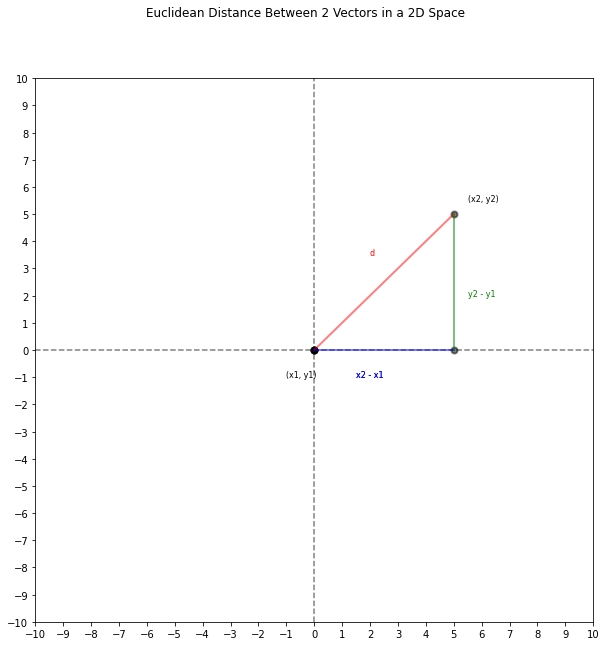

In [14]:
plot_euclidean_distance()

A continuación vamos a calcular de forma **manual** la distancia Euclídea para estos dos clientes.

In [15]:
df_cl1_2 = df_clientes.T.iloc[:, :2]
df_cl1_2["diff"] = df_cl1_2["Cliente1"] - df_cl1_2["Cliente2"]
df_cl1_2

,Cliente1,Cliente2,diff
1. Edad,18,30,-12
2. Peso,90,70,20
3. Altura,180,175,5
4. Nómina,2000,1500,500


In [16]:
eucl_cl1_cl2 = (((18 - 30) ** 2) + ((90 - 70) ** 2) + ((180 - 175) ** 2) + ((2000 - 1500) ** 2)) ** 0.5
print(f"The Euclidean distance between Cliente1 and Cliente2 is {round(eucl_cl1_cl2, 1)}")

The Euclidean distance between Cliente1 and Cliente2 is 500.6


In [17]:
distances = calculate_distances(X = df_clientes, index = index, distance_func = euclidean_distances)

target_value = distances.iloc[1, 0]

distances.style.\
applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\
highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,500.600000,1000.100000,202.400000,1100.200000,1000.200000
Cliente2,500.600000,nan,1500.100000,300.300000,600.200000,1500.100000
Cliente3,1000.100000,1500.100000,nan,1200.200000,2100.100000,19.400000
Cliente4,202.400000,300.300000,1200.200000,nan,900.300000,1200.200000
Cliente5,1100.200000,600.200000,2100.100000,900.300000,nan,2100.000000
Cliente6,1000.200000,1500.100000,19.400000,1200.200000,2100.000000,nan


<font color='red', size = 10>¿Observáis algo sospechoso?</font>

<a id = "manhattan_bad"></a>
# --> Similitud basada en la distancia Manhattan (dataset sin estandarizar)
[Volver al índice](#table_of_contents)

La otra medida de distancia muy utilizada dentro del mundo del **Data Science** es la [distancia de Manhattan.](https://es.wikipedia.org/wiki/Geometr%C3%ADa_del_taxista)

Al contrario que la distancia Euclídea (donde nos desplazamos por la diagonal), en la distancia de Manhattan nos desplazamos por los catetos del triángulo (no podemos atravesar un edificio en el Eixample de Barcelona). Para ello tomamos el **valor absoluto** de la diferencia entre los elementos de cada vector.

La forma para calcular la distancia de Manhattan para N dimensiones viene dada por la siguiente fórmula:

![Distancia_Manhattan_General](Pictures/Distancia_Manhattan_General.svg)

In [24]:
manh_cl1_cl2 = (np.abs((18 - 30)) + np.abs((90 - 70)) + np.abs((180 - 175)) + np.abs((2000 - 1500)))
print(f"The Manhattan distance between Cliente1 and Cliente2 is {round(manh_cl1_cl2, 1)}")

The Manhattan distance between Cliente1 and Cliente2 is 537


In [ ]:
distances = calculate_distances(X = df_clientes, index = index, distance_func = manhattan_distances)

target_value = distances.iloc[1, 0]

distances.style.\
applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\
highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,537.000000,1026.000000,240.000000,1130.000000,1030.000000
Cliente2,537.000000,nan,1521.000000,323.000000,623.000000,1523.000000
Cliente3,1026.000000,1521.000000,nan,1234.000000,2130.000000,30.000000
Cliente4,240.000000,323.000000,1234.000000,nan,930.000000,1230.000000
Cliente5,1130.000000,623.000000,2130.000000,930.000000,nan,2100.000000
Cliente6,1030.000000,1523.000000,30.000000,1230.000000,2100.000000,nan


<font color='red', size = 10>¿Observáis algo sospechoso?</font>

<a id = "euclidea_bien"></a>
# --> Similitud basada en la distancia Euclídea (dataset estandarizado)
[Volver al índice](#table_of_contents)

**En los dos ejemplos que hemos visto previamente, sucede que cada una de nuestras variables tienen una escala diferente.**

La implicación más inmediata de esto es que la variable de **Nómina** "aporta" la mayor cantidad en el cómputo global (tiene mayor peso). Esto puede llegar a provocar que pensemos que el Cliente5 y Cliente6 son **muy diferentes** cuando en realidad son la misma persona (exceptuando la nómina).

In [18]:
df_clientes

,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,18,90,180,2000
Cliente2,30,70,175,1500
Cliente3,21,77,170,3000
Cliente4,25,60,183,1800
Cliente5,33,80,185,900
Cliente6,33,80,185,3000


Una solución a esto es **estandarizar** nuestros valores. Para ello podemos llegar a utilizar diferentes técnicas.

Para ello podemos **restar la media de cada columna y dividir entre la desviación típica de cada columna**. De esta forma nuestros valores pasan a tener una media de 0 y una desviación típicia de 1.

In [19]:
# Hacemos la estandarización de forma manual, aplicando a una única columna.
edad_mean = df_clientes["1. Edad"].mean()
edad_dt = df_clientes["1. Edad"].std(ddof = 0)# degres of freedom

print(f"Edad media {round(edad_mean, 2)}, desviación típica de la edad {round(edad_dt, 2)}")
#estandarizamos
(df_clientes["1. Edad"] - edad_mean)/edad_dt

Edad media 26.67, desviación típica de la edad 5.79


Cliente1   -1.496132
Cliente2    0.575435
Cliente3   -0.978240
Cliente4   -0.287718
Cliente5    1.093327
Cliente6    1.093327
Name: 1. Edad, dtype: float64

<font color='red', size = 10>¿Es eficiente nuestra forma de trabajar?</font>

In [20]:
# Hacemos la estandarización de forma manual, pero esta vez lo hacemos aplicando operaciones vectoriales

mean_matrix = df_clientes.mean()
std_matrix = df_clientes.std(ddof = 0)

scaled_matrix = ((df_clientes - mean_matrix)/std_matrix)
scaled_matrix.T

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,-1.496132,0.575435,-0.978240,-0.287718,1.093327,1.093327
2. Peso,1.484749,-0.661876,0.089443,-1.735189,0.411437,0.411437
3. Altura,0.060302,-0.844232,-1.748766,0.603023,0.964836,0.964836
4. Nómina,-0.043685,-0.698963,1.266871,-0.305796,-1.485297,1.266871


In [22]:
mean_df = df_clientes.mean()
sd_df = df_clientes.std(ddof = 0)
sd_df
standarized_df = (df_clientes - mean_df)/sd_df

In [23]:
distances = calculate_distances(
    X = standarized_df,
    index = index,
    distance_func = euclidean_distances
)
target_value = distances.iloc[1, 0]
distances.style.\
applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\
highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,3.200000,2.700000,3.500000,3.300000,3.200000
Cliente2,3.200000,nan,2.800000,2.000000,2.300000,2.900000
Cliente3,2.700000,2.800000,nan,3.400000,4.400000,3.400000
Cliente4,3.500000,2.000000,3.400000,nan,2.800000,3.000000
Cliente5,3.300000,2.300000,4.400000,2.800000,nan,2.800000
Cliente6,3.200000,2.900000,3.400000,3.000000,2.800000,nan


In [ ]:
round(scaled_matrix.mean(), 1)

1. Edad     -0.0
2. Peso     -0.0
3. Altura    0.0
4. Nómina    0.0
dtype: float64

In [ ]:
round(scaled_matrix.std(ddof = 0), 1)

1. Edad      1.0
2. Peso      1.0
3. Altura    1.0
4. Nómina    1.0
dtype: float64

<font color='red', size = 10>¿Es eficiente nuestra forma de trabajar?</font>

El alumno se puede imaginar que las operaciones anteriores se realizan de forma muy habitual en muchos proyectos de **Data Science**.

Hacer este tipo de transformaciones de forma manual (o hasta vectorial) supondría un gran dolor de cabeza si hablamos de miles de columnas y decenas de pasos.

Por este motivo dentro de sklearn tenemos todo un módulo dedicado al [preprocesamiento de los datos.](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)

Los objetos que encontramos dentro este módulo se llaman **Transformers**.

Todos los transformers de sklearn tienen implementados 2 métodos: fit y transform.

**El método fit le dice al transformer a "aprender" algo de los datos. En el caso del StandardScaler aprender la media y la desviación típica de cada una de las columnas del dataset.**

**El método transform a su vez le dice al transformer a transformar/procesar nuestros datos. En el caso del StandardScaler es restar la media y dividir entre la desviación típica.**

Todos los objetos del sklearn devuelven un numpy array tras llamar al método transform o predict (caso de los modelos).

[Más sobre el StandardScaler de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [26]:
scaler = StandardScaler() # instanciamos la clase

In [27]:
scaler.mean_

AttributeError: ignored

In [28]:
# lo que hace en fit es aprender algo, en nuestro caso es aprender la media/varianza
scaler.fit(df_clientes)

StandardScaler()

In [29]:
scaler.mean_

array([  26.66666667,   76.16666667,  179.66666667, 2033.33333333])

In [30]:
# raiz cuadrada de la varianza nuestra desv tipica
scaler.var_

array([3.35555556e+01, 8.68055556e+01, 3.05555556e+01, 5.82222222e+05])

In [31]:
df_clientes

,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,18,90,180,2000
Cliente2,30,70,175,1500
Cliente3,21,77,170,3000
Cliente4,25,60,183,1800
Cliente5,33,80,185,900
Cliente6,33,80,185,3000


In [34]:
# nos dev un pandas df
scaler.transform(df_clientes)

array([[-1.49613188,  1.48474914,  0.06030227, -0.0436852 ],
       [ 0.57543534, -0.66187612, -0.84423176, -0.69896325],
       [-0.97824007,  0.08944272, -1.7487658 ,  1.26687088],
       [-0.28771767, -1.73518875,  0.60302269, -0.30579642],
       [ 1.09332714,  0.41143651,  0.9648363 , -1.4852969 ],
       [ 1.09332714,  0.41143651,  0.9648363 ,  1.26687088]])

In [39]:
pd.DataFrame(
    data = scaler.transform(df_clientes),
    index = df_clientes.index,
    columns = df_clientes.columns
)

,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,-1.496132,1.484749,0.060302,-0.043685
Cliente2,0.575435,-0.661876,-0.844232,-0.698963
Cliente3,-0.978240,0.089443,-1.748766,1.266871
Cliente4,-0.287718,-1.735189,0.603023,-0.305796
Cliente5,1.093327,0.411437,0.964836,-1.485297
Cliente6,1.093327,0.411437,0.964836,1.266871


In [25]:
scaler.fit(df_clientes) # aprendemos la media y la desviación típica de nuestras columnas

df_clientes_scaled = scaler.transform(df_clientes) # transformamos el dataset

print(type(df_clientes_scaled)) # vemos que tenemos un numpy array

# convertimos a un dataframe
df_clientes_scaled = pd.DataFrame(data = df_clientes_scaled, index = df_clientes.index, columns = df_clientes.columns)
df_clientes_scaled.T

<class 'numpy.ndarray'>


,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,-1.496132,0.575435,-0.978240,-0.287718,1.093327,1.093327
2. Peso,1.484749,-0.661876,0.089443,-1.735189,0.411437,0.411437
3. Altura,0.060302,-0.844232,-1.748766,0.603023,0.964836,0.964836
4. Nómina,-0.043685,-0.698963,1.266871,-0.305796,-1.485297,1.266871


Podemos acceder a los valores que ha **"aprendido"** el StandartScaler desde el atributo **mean_** para la media.

Y **var_** para la varianza.

In [ ]:
scaler.mean_ # media

array([  26.66666667,   76.16666667,  179.66666667, 2033.33333333])

In [ ]:
scaler.var_ # varianza

array([3.35555556e+01, 8.68055556e+01, 3.05555556e+01, 5.82222222e+05])

In [ ]:
scaler.var_ ** .5 # desviación típica

array([  5.79271573,   9.31694991,   5.52770798, 763.03487615])

In [ ]:
distances_scaled = calculate_distances(X = df_clientes_scaled, index = index, distance_func = euclidean_distances)
distances_scaled.style.highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,3.200000,2.700000,3.500000,3.300000,3.200000
Cliente2,3.200000,nan,2.800000,2.000000,2.300000,2.900000
Cliente3,2.700000,2.800000,nan,3.400000,4.400000,3.400000
Cliente4,3.500000,2.000000,3.400000,nan,2.800000,3.000000
Cliente5,3.300000,2.300000,4.400000,2.800000,nan,2.800000
Cliente6,3.200000,2.900000,3.400000,3.000000,2.800000,nan


<a id = "manhattan_bien"></a>
# --> Similitud basada en la distancia Manhattan (dataset estandarizado)
[Volver al índice](#table_of_contents)

In [ ]:
distances_scaled = calculate_distances(X = df_clientes_scaled, index = index, distance_func = manhattan_distances)
distances_scaled.style.highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,5.800000,5.000000,5.200000,6.000000,5.900000
Cliente2,5.800000,nan,5.200000,3.800000,4.200000,5.400000
Cliente3,5.000000,5.200000,nan,6.400000,7.900000,5.100000
Cliente4,5.200000,3.800000,6.400000,nan,5.100000,5.500000
Cliente5,6.000000,4.200000,7.900000,5.100000,nan,2.800000
Cliente6,5.900000,5.400000,5.100000,5.500000,2.800000,nan


<a id = "transformers"></a>
# --> Otras formas de procesar los datos
[Volver al índice](#table_of_contents)

Veamos otros ejemplos prácticos de procesamiento de datos con los transformers de sklearn.

**Otras formas de procesamiento de datos es normalizar los valores (hacer que la suma de los elementos al cuadrado sea 1) o bien podemos podemos limitar que el rango sea entre 0 y 1 (aplicar un MinMaxScaler).**

In [40]:
# este rtans trabaja a nivel de FILA, los demas a nivel de COLUMNs
scaler = Normalizer()

df_clientes_normalized = scaler.fit_transform(df_clientes)

df_clientes_normalized = pd.DataFrame(
    data = df_clientes_normalized, 
    index = df_clientes.index, 
    columns = df_clientes.columns
)

df_clientes_normalized["Norm"] = df_clientes_normalized.apply(lambda row: calculate_unit_norm(row), axis = 1)
df_clientes_normalized

,1. Edad,2. Peso,3. Altura,4. Nómina,Norm
Cliente1,0.008954,0.044772,0.089544,0.994936,1.0
Cliente2,0.019840,0.046293,0.115734,0.992003,1.0
Cliente3,0.006986,0.025617,0.056556,0.998046,1.0
Cliente4,0.013809,0.033141,0.101080,0.994230,1.0
Cliente5,0.035757,0.086685,0.200459,0.975204,1.0
Cliente6,0.010975,0.026605,0.061524,0.997691,1.0


**NOTA SUPER IMPORTANTE**

Al contrario que el **StandardScaler** que hemos aplicado antes a **nivel de columna** (estandarizamos la Edad, Peso etc).

El **Normalizer** lo aplicamos a **nivel de fila**, porque queremos normalizar cada instancia de forma individual (cada cliente de forma independiente al resto).

[Más sobre el Normalizer de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)


In [41]:
# valor max = 1 y valor min = 0
# ej valor min edad = 18 , es el 0 ...
scaler = MinMaxScaler()

df_clientes_max_scaled = scaler.fit_transform(df_clientes)

df_clientes_max_scaled = pd.DataFrame(
    data = df_clientes_max_scaled, 
    index = df_clientes.index, 
    columns = df_clientes.columns
)

df_clientes_max_scaled.columns = map(lambda name: "MMS" + name, df_clientes_max_scaled.columns)
df_clientes_max_scaled = pd.concat([df_clientes_max_scaled, df_clientes], axis = 1)
df_clientes_max_scaled

df_clientes_max_scaled.style.highlight_min(axis = 0, color = COLOR).highlight_max(axis = 0, color = COLOR_MAX)

,MMS1. Edad,MMS2. Peso,MMS3. Altura,MMS4. Nómina,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,0.000000,1.000000,0.666667,0.523810,18,90,180,2000
Cliente2,0.800000,0.333333,0.333333,0.285714,30,70,175,1500
Cliente3,0.200000,0.566667,0.000000,1.000000,21,77,170,3000
Cliente4,0.466667,0.000000,0.866667,0.428571,25,60,183,1800
Cliente5,1.000000,0.666667,1.000000,0.000000,33,80,185,900
Cliente6,1.000000,0.666667,1.000000,1.000000,33,80,185,3000


El **MinMaxScaler** hace el valor más pequeño de cada columna sea 0 y el máximo 1, el resto de los valores están comprendidos entre este rango.

**La transformación se hace a nivel de columnas.**

[Más sobre el MinMaxScaler de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

<a id = "scaler_comparison"></a>
# Comparación de los Transformers
[Volver al índice](#table_of_contents)

En esta sección vamos a ver como afectan las diferentes transformaciones a la distribución y el rango de valores de un dataset.

In [42]:
boston = load_boston()

y = pd.DataFrame(boston["target"])
y_standarized = pd.DataFrame(StandardScaler().fit_transform(y))
y_min_max = pd.DataFrame(MinMaxScaler().fit_transform(y))
y_normalized = pd.DataFrame(Normalizer().fit_transform(y.T)).T # nota que hacemos el transpose con el Normalizer
y_log = pd.DataFrame(np.log(y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

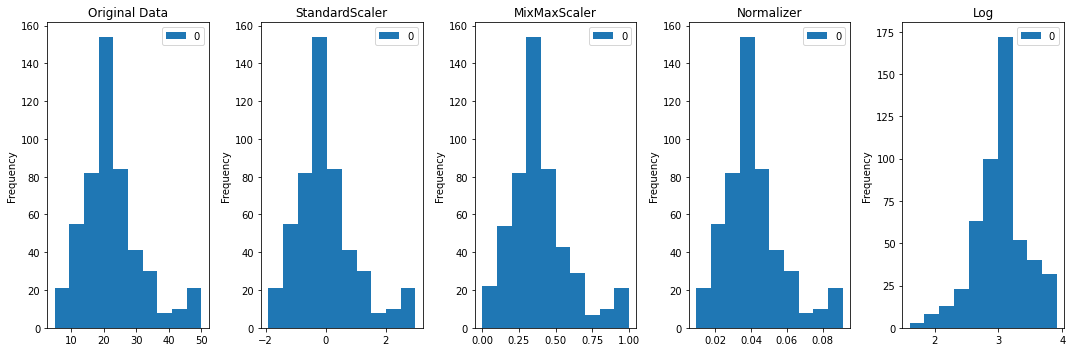

In [43]:
KIND = "hist"

fig = plt.figure(figsize = (15, 5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1, 5)

y.plot(kind = KIND, ax = ax1, title = "Original Data")
y_standarized.plot(kind = KIND, ax = ax2, title = "StandardScaler")
y_min_max.plot(kind = KIND, ax = ax3, title = "MixMaxScaler")
y_normalized.plot(kind = KIND, ax = ax4, title = "Normalizer")
y_log.plot(kind = KIND, ax = ax5, title = "Log")

plt.tight_layout();

<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#table_of_contents)

Las principales conclusiones que podemos extraer de este notebook son:

1. La distancia Euclídea o la de Manhattan son dos formas de calcular la proximidad entre dos vectores en un espacio N dimensional. Esta distancia se puede utilizar en determinados contextos como "proxy" a similitud entre clientes. Algumos de los algoritmos que usan estas distancias son KMeans o KNN.

2. Si nuestro dataset tiene variables que presentan diferentes escalas, es **fundamental** estandarizar antes estos valores (utilizando el StandardScaler o bien el MinMaxScaler) para que el aporte de cada atributo sea ~ el mismo.

3. No debemos reinventar la rueda y siempre debemos utilizar los **Transformers** de sklearn para hacer el procesamiento de los datos. Estos están optimizados para DataFrames y Arrays de Numpy, son fáciles de utilizar y funcionan muy bien con el resto del ecosistema Python (p.e: los sklearn Pipelines).